Ce document contient une implémentation (inâchevée) de l'heuristique résolvant un problème de tournée de véhicules selon les méthodes choisies.

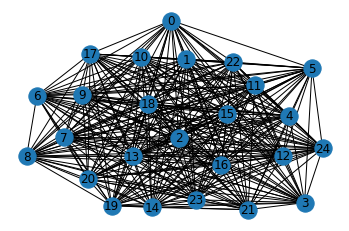

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import math
import random

random.seed()

%matplotlib inline

# Création du graphe
graph = nx.Graph()

# Ajout des noeuds
for i in range(25):
    graph.add_node(i)
    
# Ajout des côtés (avec leur coûts)
for n in graph.nodes:
    for m in graph.nodes:
        if n == m:
            continue
        graph.add_edge(n, m, weight=random.uniform(0.5, 4.0))
        
# Positionnement du layout
pos = nx.spring_layout(graph)

# Dessin du graphe
nx.draw_networkx_nodes(graph, pos)
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_labels(graph, pos)

plt.axis('off')
plt.show()

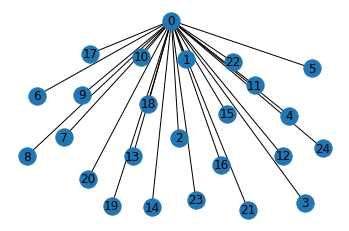

In [3]:
import copy

# On créé une copie du graphe
init = copy.deepcopy(graph)
init.remove_edges_from(list(init.edges))

# Création de la solution initiale
start = 0
for n in init.nodes:
    if n == start:
        continue
    init.add_edge(start, n, weight=graph.edges[(start, n)]['weight'])
    
# Dessin du graphe
nx.draw_networkx_nodes(init, pos)
nx.draw_networkx_edges(init, pos)
nx.draw_networkx_labels(init, pos)

plt.axis('off')
plt.show()

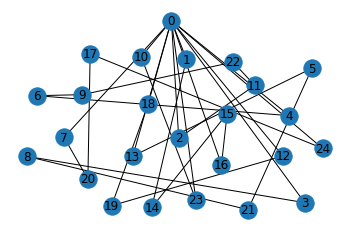

Il y a 6 routes :
[0, 1, 14, 15, 16]
[0, 2, 11, 22, 9, 6, 4]
[0, 3, 8, 21, 5, 13]
[0, 7, 20, 17, 24]
[0, 10, 23]
[0, 12, 19, 18]

Le coût total est de : 25.431182489661705


In [4]:
import operator

# Algorithme de Clake & Wright
a = 1.2
u = 0.5
v = 1.5

# On créé une copie du graphe
sol = copy.deepcopy(init)

# Définition de la fonction qui calcule le "saving"
def saving(i, j):
    ci0 = 0.0 if start == i else graph.edges[(start, i)]['weight']
    cj0 = 0.0 if start == j else graph.edges[(start, j)]['weight']
    cij = graph.edges[(i, j)]['weight']

    return (ci0 + cj0 - a * cij + u * abs(ci0 - cj0))

# Définition de la fonction permettant de fusionner deux sommets
def doFusion(i, j):
    sol.add_edge(i, j, weight=graph.edges[(ri, rj)]['weight'])
    fusions.append((i, j))
    
    totalRoute = calculateRoute(i, [i], 0.0)
    
    if totalRoute[0] > maximum:
        for r in totalRoute[1]:
            if r in linkedToStart:
                linkedToStart.remove(r)

# Définition de la fonction permettant de déterminer la route auquel appartient un point
def findRoute(j, route):
    for i in fusions:
        if j in i:
            if j == i[0]:
                jn = i[1]
            else:
                jn = i[0]
                
            if jn not in route: 
                route.append(jn)
                return findRoute(jn, route)

    return route

# Définition de la fonction permettant de déterminer la route auquel appartient un point + son coût total
def calculateRoute(j, route, total):
    for i in fusions:
        if j in i:
            if j == i[0]:
                jn = i[1]
            else:
                jn = i[0]
                
            if jn not in route: 
                route.append(jn)
                total += graph.edges[(j, jn)]['weight']
                
                return calculateRoute(jn, route, total)
            
    return (total, route)

# Définition de la fonction permettant de calculer toutes les routes d'un graphe
def getAllRoutes(graph, start, current, currentRoute, routes):
    returned = False
    for e in graph.edges:
        if current in e:
            if current == e[0]:
                n = e[1]
            else:
                n = e[0]
                
            # On vérifie si la route a déjà été empruntée
            if (current == start):
                alreadyPick = False
                for r in routes:
                    if n in r:
                        alreadyPick = True
                        break
                    
                if alreadyPick:
                    continue
                
            # La route courante est terminée
            if n == start:
                returned = True
                continue
                
            if n not in currentRoute:
                currentRoute.append(current)

                # On poursuit l'exploration
                return getAllRoutes(graph, start, n, currentRoute, routes)
    
    if returned:
        currentRoute.append(current)
        routes.append(currentRoute)

        return getAllRoutes(graph, start, start, [], routes)
    
    return routes

# Définition de la fonction permettant de calculer le coût total des routes
def totalCost(routes):
    total = 0.0
    for route in routes:
        for i in range(len(route)-1):
            total += graph.edges[(route[i], route[i+1])]['weight']
            
    return total
    
# On calcule le "saving" de tous les couples existants
savings = {}
for i in init.nodes:
    if i == start:
        continue
    for j in init.nodes:
        if j == start:
            continue
        if j == i:
            continue
        if (i, j) in savings.keys() or (j, i) in savings.keys():
            continue
        savings[(i, j)] = saving(i, j)

# On trie la liste du plus grand "saving" au plus petit
savingsList = sorted(savings.keys(), key = lambda t : savings[t], reverse = True)

# On définit une liste courante des points reliés au point de départ
linkedToStart = list(graph.nodes)

# On tient un journal des fusions
fusion_to = []
fusions = []

maximum = 1.0

# On procède au travers de la liste 
for sav in savingsList:
    ri = sav[0]
    rj = sav[1]
    
    if ri in linkedToStart and rj in linkedToStart:
        if ri in fusion_to:
            if rj in fusion_to:
                if rj not in findRoute(ri, [ri]) and ri in linkedToStart and rj in linkedToStart:
                    linkedToStart.remove(ri)
                    linkedToStart.remove(rj)

                    if (ri, 0) in sol.edges:
                        sol.remove_edge(ri, 0)

                    if (rj, 0) in sol.edges:
                        sol.remove_edge(rj, 0)

                    doFusion(ri, rj)
                    
            elif ri in linkedToStart:
                linkedToStart.remove(ri)

                if (ri, 0) in sol.edges:
                    sol.remove_edge(ri, 0)

                fusion_to.append(rj)
                
                doFusion(ri, rj)

        elif rj in fusion_to and rj in linkedToStart:
            linkedToStart.remove(rj)

            if (rj, 0) in sol.edges:
                sol.remove_edge(rj, 0)

            fusion_to.append(ri)
            
            doFusion(ri, rj)

        else:
            fusion_to.append(ri)
            fusion_to.append(rj)

            doFusion(ri, rj)

# Dessin du graphe
nx.draw_networkx_nodes(sol, pos)
nx.draw_networkx_edges(sol, pos)
nx.draw_networkx_labels(sol, pos)

plt.axis('off')
plt.show()

routes = getAllRoutes(sol, start, start, [], [])
print("Il y a " + str(len(routes)) + " routes :")
for route in routes:
    print(route)
    
print("\nLe coût total est de :", totalCost(routes))

In [8]:
import math

# Définition de la fonction renvoyant la somme des coûts des routes
def contentValue(instance):
    return totalCost(instance)

# Définition de la fonction générant tous les voisins valides d'une solution
def getNeighbourhood(instance):
    len_instance = len(instance)
    for i in range(len_instance):
        len_instancebis = len(instance[i])
        
        # Si la route ne contient que deux éléments, on ne la modifie pas
        if (len_instancebis <= 2):
            continue
            
        for j in range(len_instancebis):
            node = instance[i][j]
            initialpos = (i, j)
            
            if node == start:
                continue
            
            # On clone l'instance
            instance_neighbour = copy.deepcopy(instance)
            instance_neighbour[i].pop(j)
            
            for ib in range(len_instance):
                len_subneighbour = len(instance_neighbour[ib])
                for jb in range(len_subneighbour):
                    # Workaround pour éviter la duplication du voisinage
                    if ib == initialpos[0] and jb == initialpos[1] - 1:
                        continue
                        
                    instance_neighbour[ib].insert(jb + 1, node)
                    
                    # On relâche une copie profonde pour au cas où ce voisin serait l'optimum local
                    yield copy.deepcopy(instance_neighbour)
                    
                    # On supprime l'élément précedemment inséré :
                    if (jb + 1) >= len_subneighbour:
                        instance_neighbour[ib].pop()
                    else:
                        instance_neighbour[ib].pop(jb + 1)

# Définition de la méta-heuristique permettant d'améliorer la solution
def tabuSearch(init, size, max_iteration):
    # Déclaration du nombre d'itérations pour le processus de méta-heuristique
    iter_nb = 0
    
    # Déclaration de la liste "tabou", permettant de temporairement "interdire" certains voisins
    tabu_list = list()

    # Déclaration des variables "solutions" pour la recherche du voisin optimal non tabou
    current = init
    optimum_local = current
    optimum_global = current

    # Déclaration des variables "valeurs" pour la recherche du voisin optimal non tabou
    best_local = math.inf
    best_global = math.inf

    # Déclaration des variables qui serviront uniquement pour l'affichage
    tabu_nb = 0
    best_finding_local = 0
    best_finding_global = 0
    
    # Processus de méta-heuristique
    while (iter_nb < max_iteration):
        iter_nb = iter_nb + 1
        
        best_local = math.inf
        
        # On parcours tous les voisins de l'élément courante
        for neighbour in getNeighbourhood(current):
            neighbour_value = contentValue(neighbour)

            if neighbour_value < best_local:
                if any(neighbour == tabu for tabu in tabu_list):
                    tabu_nb = tabu_nb + 1
                else:
                    # Meilleure solution non-taboue trouvée
                    optimum_local = neighbour
                    best_local = neighbour_value
                    best_finding_local += 1
        
        # On met a jour la meilleure solution rencontrée
        if best_local < best_global:
            optimum_global = optimum_local
            best_global = best_local
            best_finding_global = best_finding_global + 1

        # On passe au meilleur voisin non-tabou trouvé
        current = optimum_local
        
        # On met a jour la liste tabou
        tabu_list.append(current)
        
        if len(tabu_list) >= size:
            tabu_list.pop(0)

    return optimum_global

# Exécution de la méta-heuristique
print("tabou de taille 5")
routes = getAllRoutes(sol, start, start, [], [])
solution = tabuSearch(routes, 5, 20)

print("valeur finale = " + str(contentValue(solution)))
print(solution)

tabou de taille 5
valeur finale = 20.251169549867647
[[0, 3, 1, 14, 15, 16], [0, 8, 2, 11, 22, 9, 6, 4], [0, 13], [0, 21, 20, 17, 24], [0, 5, 7, 10], [0, 12, 19, 18, 23]]
